In [2]:
from drnn import DRNN
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import hp

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
expit = lambda x : np.exp(x)/(1 + np.exp(x))

def gendata_mcar(N, T, p, seed, r = 1) : 
    """ 
    Generates Gaussian data, with latent dimension r = 2

    required : N, d are both EVEN positive integers
    """
    np.random.seed(seed = seed)

    ## Data Matrix (N * T * n * d)
    Data = np.zeros( (N, T) )
    #true_Mean = np.zeros( (N, T) )
    #true_Cov = np.zeros( (N, T) )

    u_1 = np.random.uniform(-1, 1, (N, r))
    u_2 = np.random.uniform(0.2, 1, (N, r))

    v_1 = np.random.uniform(-2, 2, (T, r))
    v_2 = np.random.uniform(0.5, 2, (T, r))

    user_std = 0.3
    time_std = 0.3

    #even_ones = np.repeat([0, 1], d/2)
    #odd_ones = np.repeat([1, 0], d/2)
    #U = np.random.uniform(size=(N,r)) * user_range * 2 - user_range
    #V = np.random.uniform(size=(T,r)) * time_range * 2 - time_range
    Y0 = 1/np.sqrt(r) * np.matmul(u_1, v_1.transpose())

    a = np.random.normal(0, user_std, size=N)
    b = np.random.normal(0, time_std, size=T)
    eps = np.random.normal(0, 0.05, size=(N, T))

    # treatment effect
    # delta(i,j) = a(i) + b(t) + eps(i,t)

    aa = np.broadcast_to(a.reshape(N,1), (N,T))
    bb = np.broadcast_to(b, (N,T))
    delta = aa + bb + eps 
    Y1 = Y0 + delta 

    Y1 += np.random.normal(0, 0.001, size=(N,T))
    Y0 += np.random.normal(0, 0.001, size=(N,T))
    #D = np.stack([Y0, Y1], axis=-1)
    
    Masking = np.zeros( (N, T) )

    Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))

    # for sim purpose, last row, last column is observed
    Masking[N - 1, T - 1] = 1
    Data = np.zeros((N, T))
    Data[Masking == 1] = Y1[Masking == 1]
    Data[Masking == 0] = Y0[Masking == 0]


    return Data, Masking

(200, 200)

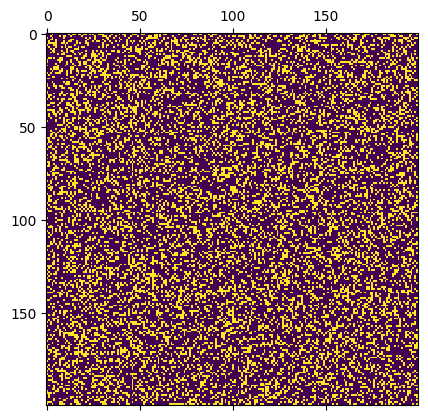

In [93]:
Z, M = gendata_mcar(200, 200, p = 0.3, seed = 42)
plt.matshow(M)
Z.shape

In [44]:
N, T = M.shape
obvs_inds = np.nonzero(M == 1)
rq_obvs_inds_x = obvs_inds[0][np.logical_and(obvs_inds[0] >= T // 2, obvs_inds[1] >= N // 2)]
rq_obvs_inds_y = obvs_inds[1][np.logical_and(obvs_inds[1] >= N // 2, obvs_inds[0] >= T // 2)]
rq_inds = (rq_obvs_inds_x, rq_obvs_inds_y)


In [27]:
import simulate_drnn

In [30]:
Z, T, M = simulate_drnn.gendata_nonlin_mcar(200, 200, p = 0.9, non_lin = "expit", seed = 20)

In [31]:
drnn_spc = {
    'row_eta': hp.uniform('row_eta', 0, 0.7),
    'col_eta': hp.uniform('col_eta', 0, 0.7)
}

mcar_drnn = DRNN(eta_space = hp.uniform('eta', 0, 0.7), drnn_eta_space=drnn_spc)
Z = np.ma.masked_array(Z, np.logical_not(M))
r_dist, c_dist = mcar_drnn.distances(Z)


In [144]:
Z

masked_array(
  data=[[-0.3698052729001645, -0.23675915980302475, -0.06854172207103619,
         ..., -0.7219790789087893, -0.7006260364160712,
         -0.5082980193147738],
        [-0.32097347382425495, -0.3792695874827092, -0.587747036329631,
         ..., 1.2444519671141612, --, --],
        [0.35084258348821046, 0.17047547696319434, 0.902837407361802,
         ..., -0.8622589823939075, 0.19757599968284167,
         0.127452690291471],
        ...,
        [-0.21158250302647927, -0.7928391397385793, -1.352691758582859,
         ..., 1.4428313880080268, -0.4176321753230708,
         0.14980922236902192],
        [-0.9968322180262419, 0.8839078903549289, -0.0678180694079438,
         ..., -0.05828463426886366, -0.3229639308122517,
         -0.7595770690169322],
        [-0.0055539632635052604, 0.11191320320882425, 0.4182040526948347,
         ..., -0.22750025066082907, -0.05779603110448564, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, 

In [32]:
np.max(r_dist[~np.isinf(r_dist)])

np.float64(30.493685620326914)

In [62]:
eta_drnn_col

np.float64(0.0)

In [63]:
eta_drnn_row

np.float64(0.2)

In [92]:
def gendata_mcar(N, T, p, seed, r = 4) : 
    """ 
    Generates Gaussian data, with latent dimension r = 4
    """
    np.random.seed(seed = seed)

    ## Data Matrix (N * T * n * d)
    Data = np.zeros( (N, T) )
    #true_Mean = np.zeros( (N, T) )
    #true_Cov = np.zeros( (N, T) )

    user_range = 0.9
    time_range = 0.9

    user_std = 0.3
    time_std = 0.3

    U = np.random.uniform(size=(N,r)) * user_range * 2 - user_range
    V = np.random.uniform(size=(T,r)) * time_range * 2 - time_range
    Y0 = 1/np.sqrt(r) * np.matmul(U, V.transpose())

    a = np.random.normal(0, user_std, size=N)
    b = np.random.normal(0, time_std, size=T)
    eps = np.random.normal(0, 0.05, size=(N, T))

    # treatment effect
    # delta(i,j) = a(i) + b(t) + eps(i,t)

    aa = np.broadcast_to(a.reshape(N,1), (N,T))
    bb = np.broadcast_to(b, (N,T))
    delta = aa + bb + eps 
    Y1 = Y0 + delta 

    Y1 += np.random.normal(0, 0.001, size=(N,T))
    Y0 += np.random.normal(0, 0.001, size=(N,T))
    #D = np.stack([Y0, Y1], axis=-1)
    
    Masking = np.zeros( (N, T) )

    Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))

    # for sim purpose, last row, last column is observed
    Masking[N - 1, T - 1] = 1
    Data = np.zeros((N, T))
    Data[Masking == 1] = Y1[Masking == 1]
    Data[Masking == 0] = Y0[Masking == 0]

    return Data, Masking

In [68]:
rq_inds = (N - 1, T - 1)
eval_mask = np.logical_not(M)
eval_mask[rq_inds] = 1

masked_Z = np.ma.masked_array(Z, eval_mask)

eta_drnn_row, eta_drnn_col = mcar_drnn.search_eta_drnn(masked_Z, M, max_evals = 100)
eta_star_row = mcar_drnn.search_eta_snn(masked_Z, M, nn_type = "u", max_evals=100)
eta_star_col = mcar_drnn.search_eta_snn(masked_Z, M, nn_type = "i", max_evals=100)



row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = [rq_inds]
# for b in range(len(rq_inds[0])):
#   flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_drnn_row, eta_drnn_col, flattened_inds, row_dists, col_dists)
truth = Z[rq_inds]
err = mcar_drnn.avg_error(est[rq_inds], truth)
snn_unit_est = mcar_drnn.snn_estimate(masked_Z, M, eta_star_row, flattened_inds, row_dists, "u")
snn_time_est = mcar_drnn.snn_estimate(masked_Z, M, eta_star_col, flattened_inds, col_dists, nn_type = "i")
unit_err = mcar_drnn.avg_error(snn_unit_est[rq_inds], truth)
time_err = mcar_drnn.avg_error(snn_time_est[rq_inds], truth)

print(err)
print(unit_err)
print(time_err)


0.005996660400794241
0.08786652522877604
0.26356716237220656


In [26]:
row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = []
for b in range(len(rq_inds[0])):
  flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_star_row, eta_star_col, flattened_inds, row_dists, col_dists)
truth = Z[rq_inds]
err = mcar_drnn.avg_error(est[rq_inds], truth)

here
here
here
here
here


In [111]:
Z = np.array([[1, 2, 3, 4], [0, 2, 4, 3], [1, 2, 5, 1], [1, 2, 3, 100]])
M = np.array([[1, 0, 1, 0], [1, 1, 1, 1], [0, 1, 0, 0], [1, 1, 1, 0]])
act_M = np.logical_not(M)
Z_m = np.ma.masked_array(Z, mask = act_M)
row_dists, col_dists = mcar_drnn.distances(Z_m, M = None)
#row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
est = mcar_drnn.estimate(Z_m, M, 0, 1, [(3, 3)], row_dists, col_dists)

[True False True False]
[False  True  True False]
--
[[--]
 [3]
 [--]
 [--]]
[1 2 3 --]


In [107]:
row_dists[3]

masked_array(data=[0.0, 0.6666666666666666, 0.0, inf],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [109]:
est

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan,  3.]])

In [44]:
test_Z = np.array([[1, 2, 3], [4, 5, 6]])
mask = np.array([[1, 0, 1], [1, 0, 1]])
m_test_Z = np.ma.masked_array(test_Z, np.logical_not(mask))
mcar_drnn.distances(m_test_Z)

(masked_array(
   data=[[inf, 9.0],
         [9.0, inf]],
   mask=[[False, False],
         [False, False]],
   fill_value=1e+20),
 masked_array(
   data=[[inf, --, 4.0],
         [--, inf, --],
         [4.0, --, inf]],
   mask=[[False,  True, False],
         [ True, False,  True],
         [False,  True, False]],
   fill_value=1e+20))

In [37]:
row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = []
for b in range(len(rq_inds[0])):
  flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_star_row, eta_star_col, flattened_inds, row_dists, col_dists)
est[rq_inds]

c:\Users\Caleb\HeartstepsDNN\DRNN\drnn.py:109: UserWarning: Warning: converting a masked element to nan.
  ests[i, j] = np.mean(row_Ys - col_Ys + Z[s_unit_nn][s_time_nn]) # this is len(s_unit_nn) x len(s_time_nn)


array([ 0.15819007, -0.13098725, -0.97126471, ..., -0.70994375,
       -0.77141201, -0.74979711])

In [36]:
# new ssplit
direc = "."
drnn_err = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_abs_eta.npy")
unit_err = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_usvt_abs_err.npy")

drnn_ests = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_estimates.npy", allow_pickle=True)
unit_ests = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_unit_estimates.npy", allow_pickle=True)
time_ests = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_time_estimates.npy", allow_pickle=True)
usvt_ests = np.load(direc + "/drnn_full_seed_ssplit_mcar_N4_6_blin_uv11_d4_p5_usvt_estimates.npy", allow_pickle=True)


In [19]:
np.mean(drnn_eta, axis = 1)

array([[3.26287416, 3.21012736, 4.41757198, 4.23023267],
       [3.51155538, 3.07500328, 4.20838942, 4.54255612],
       [2.35355272, 3.08371766, 4.76978038, 4.91452761],
       [1.58582891, 4.2014089 , 4.87234474, 4.28961732]])

In [23]:
np.mean(time_eta, axis = 1)

array([[4.41757198, 4.41757198],
       [4.20838942, 4.20838942],
       [4.76978038, 4.76978038],
       [4.87234474, 4.87234474]])

In [21]:
np.mean(unit_eta, axis = 1)

array([[4.41757198, 2.22396872],
       [2.42449669, 4.20838942],
       [2.04909441, 4.76978038],
       [3.69726097, 4.87234474]])

In [91]:
# lin
direc = "experimental_results"
drnn_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_eta.npy")
unit_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_usvt_abs_err.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'experimental_results/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_err.npy'

In [45]:
# non lin
direc = "experimental_results"
drnn_err = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_abs_eta.npy")
unit_err = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_full_etarand_ssplit_mcar_N4_7_blin_uv11_d4_p5_usvt_abs_err.npy")

In [39]:
drnn_eta

array([[[0.72746856, 0.08082607, 1.0253298 , 0.45232819],
        [0.92320475, 0.59711818, 3.15716637, 2.55901144],
        [0.11874382, 1.96101792, 0.69914723, 1.43754237],
        [2.47102949, 0.18925796, 2.73128068, 2.87104706],
        [2.18211812, 0.88685697, 0.73912314, 2.84414331],
        [2.37969395, 1.0797541 , 0.34089535, 3.30094505],
        [0.15715628, 2.42321842, 0.51916395, 1.67126381],
        [0.56404733, 2.16123298, 0.54809934, 0.15030665],
        [2.74866301, 0.22242522, 0.16663039, 1.05262554],
        [0.31309807, 1.29521254, 1.29807348, 2.64417896],
        [1.51244509, 0.2373827 , 1.19372979, 1.13572045],
        [0.31746061, 1.53450731, 1.57781677, 0.08991369],
        [0.57827815, 2.0668107 , 2.24991024, 1.36201891],
        [1.17796059, 2.7789275 , 1.6334622 , 1.95832545],
        [0.0379964 , 0.07982948, 0.88057172, 0.24753434],
        [2.65281079, 1.87164496, 2.65281079, 1.87164496],
        [3.01350709, 3.4140561 , 2.27966635, 0.89463099],
        [1.045

In [267]:
unit_err

array([[0.19049707, 0.44274251, 0.7359814 , 0.06691642, 0.25980295],
       [0.14018141, 0.23519809, 0.09672301, 0.23492119, 0.31464201],
       [0.10535198, 0.21144758, 0.30424297, 0.1759658 , 0.12380815]])

In [252]:
np.mean(usvt_err, axis = 1)

array([0.27203086, 0.29372164, 0.22382277, 0.31656219])

In [170]:
np.mean(usvt_none_err, axis = 1)

array([0.23176358, 0.30861153, 0.20899622, 0.32505002])

In [168]:
print(np.mean(usvt_err, axis = 1))

[0.22577931 0.30861153 0.20899622 0.32505002]


In [46]:
print(np.mean(drnn_eta, axis = 1))
print(np.mean(unit_eta, axis = 1))
print(np.mean(time_eta, axis = 1))

[[1.27332686 1.23006019 1.54615019 1.48058143]
 [1.31580165 1.30992265 1.4729363  1.58989464]
 [1.01619343 1.42656792 1.66942313 1.72008466]
 [1.02162142 1.07830606 1.70532066 1.50136606]]
[[1.54615019 0.8527441 ]
 [0.81051823 1.4729363 ]
 [0.99446249 1.66942313]
 [0.97923836 1.70532066]]
[[1.54615019 1.54615019]
 [1.4729363  1.4729363 ]
 [1.66942313 1.66942313]
 [1.70532066 1.70532066]]


In [151]:
time_err.shape

(4, 30)

In [139]:
print(drnn_err[1])
print(unit_err[1])
print(time_err[1])

[2.42934940e-03 1.29768672e-02 4.65932916e-02 1.78040996e-01
 1.44929294e-01 1.45246665e-01 1.84626136e-01 7.60284072e-02
 1.29660094e-02 5.53312483e-01 2.64749810e-01 7.64822701e-04
 1.99153924e-02 2.24774452e-01 3.96110555e-01 6.04077505e-06
 2.16726590e-01 2.46072400e-01 1.01351652e-01 6.47672142e-03
 1.20048046e-01 7.46675163e-05 1.52899070e-01 1.68927305e-02
 1.28290930e-02 7.62160529e-03 4.53408707e-02 4.33406508e-02
 1.32820265e-01 2.21248150e-01]
[2.06139398e-02 5.59055190e-02 1.02070369e-01 3.77911628e-02
 4.07020568e-01 2.37245992e-02 8.09593070e-02 1.12080865e-04
 3.10315843e-03 5.14213356e-01 1.61391339e-02 1.38465802e-02
 2.96174447e-02 2.25622341e-01 3.38360359e-02 1.42661439e-03
 3.54536217e-01 6.83388165e-01 4.28009166e-01 1.05633689e-01
 5.22571505e-02 5.16358514e-02 2.53199438e-01 8.04085611e-05
 1.48270261e-01 4.55968018e-02 3.11504218e-03 8.02514112e-03
 2.63075629e-01 1.23216247e-01]
[2.20998722e-01 1.43983217e-01 6.00814466e-02 1.79526352e-01
 6.95949280e-02 8.352

In [257]:
np.std(drnn_err, axis =1)
np.std(unit_err, axis = 1)
np.std(time_err, axis = 1)

array([0.22358487, 0.24169616, 0.04745705, 0.05238776])

In [228]:
usvt_err

array([[2.32266766e-01, 4.34600401e-01, 5.97453611e-01, 1.04824433e-01,
        1.42354041e-01, 1.25777377e-01, 1.93258314e-01, 1.09489100e-01,
        8.18878380e-02, 1.00930604e-01, 8.69216102e-02, 6.42165385e-03,
        1.60874612e-01, 5.51877229e-01, 5.24522760e-01, 2.78002338e-01,
        4.23078037e-01, 4.85445380e-01, 2.49379953e-02, 7.75146770e-02,
        1.24383424e-05, 2.10947591e-01, 2.60071157e-01, 5.65432155e-01,
        1.03149644e-01, 1.38031260e-01, 3.00617030e-02, 1.63203784e-01,
        4.17791461e-01, 9.21942740e-02],
       [1.04116040e-01, 1.09071714e-01, 1.38949257e-01, 4.62974814e-01,
        3.98327684e-01, 2.55227742e-01, 1.50816793e-01, 1.27219361e-01,
        1.37099487e-01, 7.43751037e-01, 1.69196179e-01, 1.06883168e-01,
        3.61920098e-01, 7.40038723e-02, 7.05857467e-02, 3.47871045e-01,
        1.92285476e-01, 3.39861474e-01, 1.51310356e-01, 9.04896988e-01,
        3.09281830e-01, 6.04386145e-02, 6.27526857e-01, 2.15438684e-01,
        2.14766785e-01,

In [117]:
_eta

array([[0.07946436, 0.25661346, 0.0116677 , 0.23973342, 0.18415741],
       [0.27480137, 0.14236181, 0.29941581, 0.01302101, 0.22232017],
       [0.26547061, 0.29813501, 0.29791452, 0.2686998 , 0.28145807],
       [0.2998253 , 0.29996293, 0.28981846, 0.29988363, 0.26329515]])

In [11]:
import matplotlib as mpl

In [53]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size


lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D']


In [15]:
time_err.shape

(4, 30, 2)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_28852\2317079737.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.errorbar(T_values, TimeNN_errors, yerr=tnn_stderr, fmt='s', color = "orange", marker='s', linestyle='None', markersize=12, label=rf'Time-NN: $T^{{{tnn_slope:.2f}}}$')
C:\Users\Caleb\AppData\Local\Temp\ipykernel_28852\2317079737.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.75)


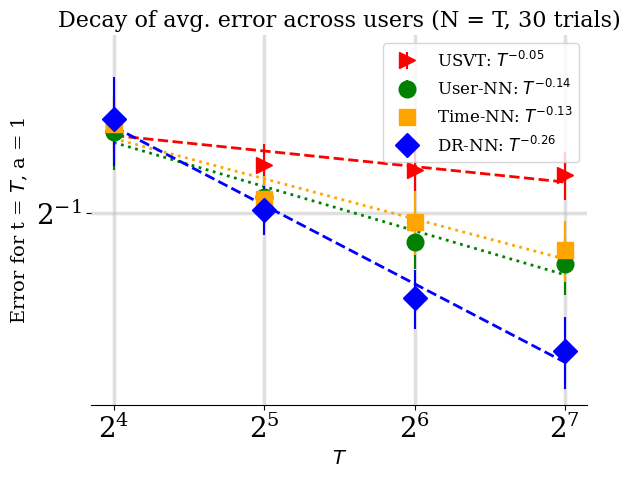

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Define T values and corresponding error rates for each method
T_values = np.array([2**4, 2**5, 2**6, 2**7])

UserNN_errors = np.nanmean(unit_err, axis = 1)
TimeNN_errors = np.nanmean(time_err, axis = 1)
DRNN_errors = np.nanmean(drnn_err, axis = 1)
USVT_errors = np.nanmean(usvt_err, axis = 1)

unn_stderr = np.nanstd(unit_err, axis = 1) / np.sqrt(unit_err.shape[1])
tnn_stderr = np.nanstd(time_err, axis = 1) / np.sqrt(time_err.shape[1])
drnn_stderr = np.nanstd(drnn_err, axis = 1) / np.sqrt(drnn_err.shape[1])
usvt_stderr = np.nanstd(usvt_err, axis = 1) / np.sqrt(usvt_err.shape[1])



# Create the plot
plt.figure()
#plt.plot(T_values, USVT_errors, 'r', linestyle='-', marker='D', markersize=8, linewidth=2, label=r'USVT: $T^{-0.46}$')

def add_regression_line(x, y, color, label, linestyle):
    # Fit a line to log-transformed data
    slope, intercept = np.polyfit(np.log2(x), np.log2(y), 1)
    plt.plot(x, 2**(intercept) * x**slope, color=color, linestyle=linestyle, linewidth=2) 
             #label=f"{label} (slope: {slope:.2f})")
    return slope

usvt_slope = add_regression_line(T_values, USVT_errors, 'red', 'USVT', '--')
unn_slope = add_regression_line(T_values, UserNN_errors, 'green', 'User-NN', ':')
tnn_slope = add_regression_line(T_values, TimeNN_errors, 'orange', 'Time-NN', ':')
drnn_slope = add_regression_line(T_values, DRNN_errors, 'blue', 'DR-NN', '--')

# Plot each method with corresponding markers, colors, and line styles
plt.errorbar(T_values, USVT_errors, yerr=usvt_stderr, fmt = 'r', marker='>', markersize=12, linestyle='None', barsabove=True, label=rf'USVT: $T^{{{usvt_slope:.2f}}}$')
plt.errorbar(T_values, UserNN_errors, yerr=unn_stderr, fmt = 'g', marker='o', markersize=12, linestyle='None', label=rf'User-NN: $T^{{{unn_slope:.2f}}}$')
plt.errorbar(T_values, TimeNN_errors, yerr=tnn_stderr, fmt='s', color = "orange", marker='s', linestyle='None', markersize=12, label=rf'Time-NN: $T^{{{tnn_slope:.2f}}}$')
plt.errorbar(T_values, DRNN_errors, fmt='bD', yerr=drnn_stderr, markersize=12, linestyle="None", label=rf'DR-NN: $T^{{{drnn_slope:.2f}}}$')

# Logarithmic scale for both axes
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.ylim(0, 0.75)
# Axis labels
plt.xlabel(r'T', fontsize=14)
plt.ylabel(r'Error for t = T, a = 1', fontsize=14)

# Title
plt.title(r'Decay of avg. error across users (N = T, 30 trials)', fontsize=16)

# Add legend
plt.legend(fontsize=12)

# Grid for better readability
#plt.grid(True, which="both", linestyle='--', linewidth=0.5)
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(True, alpha=0.4)


# Show the plot#
plt.savefig("drnn_mcar_nonlin_uv11_abserr_decay.pdf", bbox_inches = "tight")


In [289]:
np.mean(usvt_err, axis = 1)

array([0.27203086, 0.29372164, 0.22382277, 0.31656219])

In [332]:
usvt_errs = np.load('drnn_mcar_N128_abs_usvt_errors.npy')
user_nn_errs = np.load('drnn_mcar_N128_abs_unit_errors.npy')
time_nn_errs = np.load('drnn_mcar_N128_abs_time_errors.npy')
drnn_errs = np.load('drnn_mcar_N128_abs_drnn_errors.npy')

In [191]:
usvt_errs.shape

(28,)

In [302]:
usvt_errs

array([2.16184339e-01, 5.43714437e-01, 3.91585739e-01, 2.64486704e-01,
       4.89581357e-02, 8.93613081e-02, 3.33265621e-01, 8.47672345e-01,
       9.24952951e-02, 3.23889493e-01, 2.10114779e-01, 7.98956839e-01,
       1.45061208e+00, 4.98453656e-03, 1.40218029e-01, 9.43763697e-01,
       1.38451395e-02, 1.35431420e-02, 5.12074001e-03, 5.02384478e-03,
       1.49401358e-01, 1.29671857e+00, 1.47994707e+00, 4.96969595e-02,
       5.41559944e-01, 1.72945506e-01, 4.44640616e-01, 5.54406406e-02,
       7.15755927e-02, 2.39419671e-01, 4.91525406e-01, 1.01961532e-02,
       3.72377823e-01, 1.43246220e-02, 5.72391323e-01, 3.62975605e-02,
       2.59172107e-02, 9.00277441e-03, 2.63918833e-01, 9.98676641e-04,
       3.77674766e-01, 8.37615885e-02, 3.62180426e-01, 4.50930714e-01,
       4.97925063e-01, 3.51285049e-01, 1.85415633e+00, 8.51979237e-02,
       6.87054363e-03, 9.22390308e-03, 2.01115093e-03, 9.47036994e-01,
       3.05270128e-01, 3.60161328e-01, 6.12174940e-01, 1.73072373e-01,
      

In [306]:
user_nn_errs.shape

(63,)

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
usvt_data = usvt_errs  # Replace with your actual USVT data
user_nn_data = user_nn_errs  # Replace with your actual User-NN data
time_nn_data = time_nn_errs # Replace with your actual Time-NN data
dr_nn_data = drnn_errs  # Replace with your actual DR-NN data

# Combine data into a list for plotting
data = [usvt_data, user_nn_data, time_nn_data, dr_nn_data]

# Set up the plot
plt.figure(figsize=(6, 10))

# Create boxplot
box = plt.boxplot(data, patch_artist=True, widths=0.6)

# Customizing colors for each boxplot
colors = ['#FF6F61', '#4CAF50', '#FFB74D', '#1E88E5']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')  
# Set y-axis limit
#plt.ylim(0, 0.4)
plt.ylim(0, None)

# Add labels and title
plt.xticks([1, 2, 3, 4], ['USVT', 'User-NN', 'Time-NN', 'DR-NN'], fontsize=12)
plt.ylabel(r'Error for $t = T$ and $a = 1$', fontsize=14)
plt.title(r'Variation of error across users  $(N = T = 128, \; 1 \; \text{Trial})$', fontsize=16)

ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(True, alpha=0.4)

# Customize grid lines
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Show the plot
#plt.savefig("drnn_variation_abs_error_NT128.pdf", bbox_inches = "tight")

NameError: name 'usvt_errs' is not defined